In [1]:
import pandas as pd
import numpy as np
import jsonlines
from collections import Counter
from matplotlib import pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from collections import Counter
import seaborn as sns
import re
%matplotlib inline

#MAIL
Attached is the geo-data for Chennai. Here are the questions we are looking to answer using it:

1.How do we go about defining a locality of a particular business? Consider the density of different kinds of businesses across the city

Ans.For aparticular bussiness to define localty plot all the spaial data points which are relevant for the bussiness for eg. Logistics - plot all the warehouses, moving companies , storage, National and State highways and their density and other spatial features (roads) will show the locality for the Logistics market.

2.How can we identify localities in a city? Try to think of various methods to cluster the rich spacial data that has been shared

Ans.localities(markets) in a city can be identifies on the basis of density of various spatial data points.

3.How to identify the type of a locality (eg commercial, residential etc)

Ans. To identify the market type in a locality consider the locality spatial points and determine the percetage of differnet data points and the percentages will represent the type of market it is.

I think these are some questions you can start exploring. Go over the data, it's not cleaned, so let me know what sort of preprocessing would be necessary. Also, there are a couple of clusters of points I have deliberately removed. I'll be extremely impressed if you can identify those 



In [2]:
colormap=np.array(sns.hls_palette(18, l=.3, s=.8))

In [3]:
len(colormap)

18

In [4]:
location='/home/nikesh/Documents/cityscooper/chennai_place_data_4km.json'
city=[]
with jsonlines.open(location,'r') as reader:
    for obj in reader:
        city.append(obj)

In [5]:
len(city)

149566

In [6]:
#types of data available in each dictionary 
size=[]
cols=[]
for dic in city:
    size.append(len(dic))
    for item in dic:
        cols.append(item)
        
cols=set(cols)
print(len(city[1]),len(city[100]),len(city[1000]),len(city[10000]))
print(len(cols))

print('max number of attributes in a data point = ',max(size),'max number of attributes in a data point = ',min(size))
cols

15 19 17 16
23
max number of attributes in a data point =  22 max number of attributes in a data point =  0


{'address_components',
 'adr_address',
 'formatted_address',
 'formatted_phone_number',
 'geometry',
 'icon',
 'id',
 'international_phone_number',
 'name',
 'opening_hours',
 'permanently_closed',
 'photos',
 'place_id',
 'price_level',
 'rating',
 'reference',
 'reviews',
 'scope',
 'types',
 'url',
 'utc_offset',
 'vicinity',
 'website'}

In [7]:
#nos of empty and max length dictionaries
empty=[]
full=[]
for dic in city:
    if len(dic)==0:
        empty.append(dic)
    elif len(dic)==22:
        full.append(dic)
        
print(len(empty))
print(len(full))

60
215


there are sixty removed data points!!

# Function to extract fetures 

In [8]:
def extract(feature_name):
        feature_list=[]
        for dic in city:
            for item in dic:
                if item==feature_name:
                    feature_list.append(dic[feature_name])
        return(feature_list)

In [9]:
place_name=extract('name')
geometry=extract('geometry')
address=extract('formatted_address')#address for manual search on internet
place_types=extract('types')


### romoving 'point_of_interest' and 'establishent' from types

In [10]:

for item in place_types:
    item.remove('point_of_interest')
    item.remove('establishment')
   

In [11]:
#place_types

In [12]:
print(len(place_name),len(geometry),len(address),len(place_types))

149506 149506 149506 149506


since all of them are of same length we can be sure that their order corresponds to same data points

In [13]:
geometry[1]

{'location': {'lat': 13.207488, 'lng': 80.11146699999999},
 'viewport': {'northeast': {'lat': 13.2088369802915, 'lng': 80.1128159802915},
  'southwest': {'lat': 13.2061390197085, 'lng': 80.11011801970848}}}

In [14]:
lat_lng=[]
for dic in geometry:
    lat_lng.append(dic['location'])

In [15]:
lat_lng[1]

{'lat': 13.207488, 'lng': 80.11146699999999}

## lat lng as data frame

In [16]:
geo=pd.DataFrame(lat_lng)
geo.head(3)

,lat,lng
0,13.188111,80.105867
1,13.207488,80.111467
2,13.212473,80.088405


In [17]:
geo.to_pickle('/home/nikesh/Documents/cityscooper/point_density/geo.pickle')
geo1=pd.read_pickle('/home/nikesh/Documents/cityscooper/point_density/geo1.pickle')
cluster_data1=pd.read_pickle('/home/nikesh/Documents/cityscooper/point_density/test_11_data.pickle') # clusters

In [18]:
id=[]
for i in range(149506):
        id.append(i)
        
print(id[-1])

149505


In [19]:
city_df=pd.DataFrame.from_items([('Latitude',list(geo.lat)),('Longitude',list(geo.lng)),('PlaceName',place_name),
                                 ('Types',place_types),('id',id)])

In [20]:
print(len(city_df))
city_df.head(2)

149506


,Latitude,Longitude,PlaceName,Types,id
0,13.188111,80.105867,Vijaya Bank ATM,"[atm, finance]",0
1,13.207488,80.111467,India1 ATM,"[atm, finance]",1


since len(city_df)=149506 it does not contain removed points as original data has 19566 data points

# Proceesing geometry data

In [21]:
lat_lng_tuple=[]
for item in lat_lng:
    lat_lng_tuple.append((item['lat'],item['lng']))

In [22]:
lat_lng_tuple[:10]

[(13.1881106, 80.10586669999999),
 (13.207488, 80.11146699999999),
 (13.212473, 80.088405),
 (13.212577, 80.085337),
 (13.19181, 80.098342),
 (13.2021597, 80.13806629999999),
 (13.202543, 80.13906999999999),
 (13.207561, 80.111117),
 (13.2122, 80.0877),
 (13.212576, 80.085337)]

# lat and lng throughout the data are not unique

    ##reasons for repeated lat_lng
    1.Malls
    2.Multiple floor markets
    3.Repeated points as place names also not unique  as shown in few above cells
    Eg: pt index 109632 , 96133 shown in few cells below

In [23]:
lat_lng_tuple_set=set(lat_lng_tuple)
print('unique lat_lng = ',len(lat_lng_tuple_set),'\n\n total lat_lng =',len(lat_lng_tuple))

unique lat_lng =  124480 

 total lat_lng = 149506


# Processing 'types' data

# All types of labels

total=102

['doctor', 'car_rental', 'funeral_home', 'book_store', 'embassy', 'pet_store', 'political', 'painter', 'veterinary_care', 'bakery', 'food', 'spa', 'dentist', 'church', 'school', 'plumber', 'park', 'furniture_store', 'home_goods_store', 'natural_feature', 'real_estate_agency', 'lawyer', 'casino', 'gas_station', 'hospital', 'physiotherapist', 'general_contractor', 'beauty_salon', 'lodging', 'meal_delivery', 'rv_park', 'library', 'route', 'university', 'liquor_store', 'stadium', 'shoe_store', 'airport', 'fire_station', 'museum', 'local_government_office', 'car_repair', 'hair_care', 'city_hall', 'cafe', 'department_store', 'jewelry_store', 'train_station', 'courthouse', 'shopping_mall', 'movie_theater', 'clothing_store', 'car_dealer', 'bank', 'zoo', 'parking', 'atm', 'hardware_store', 'pharmacy', 'accounting', 'subpremise', 'health', 'supermarket', 'meal_takeaway', 'subway_station', 'finance', 'night_club', 'post_office', 'aquarium', 'florist', 'grocery_or_supermarket', 'roofing_contractor', 'car_wash', 'travel_agency', 'moving_company', 'bowling_alley', 'gym', 'amusement_park', 'insurance_agency', 'locksmith', 'bicycle_store', 'restaurant', 'bar', 'store', 'cemetery', 'convenience_store', 'electronics_store', 'bus_station', 'movie_rental', 'campground', 'art_gallery', 'police', 'laundry', 'transit_station', 'premise', 'storage', 'synagogue', 'mosque', 'taxi_stand', 'electrician', 'place_of_worship', 'hindu_temple']

### length of 'types' attribute

In [24]:
t_len=[]
for item in place_types:
    t_len.append(len(item))
print(len(t_len))

t_len_set=set(t_len)
print(len(t_len_set))
print(t_len_set)


149506
9
{1, 2, 3, 4, 5, 6, 7, 8, 10}


In [25]:
t1=[];t2=[];t3=[];t4=[];t5=[];t6=[];t7=[];t8=[];t10=[] #t1 has spatial points which have just one place type and so.
    
for index,item in enumerate(list(city_df.Types)):
    if len(item)==1:
        t1.append(item)
    if len(item)==2:
        t2.append(item)
    if len(item)==3:
        t3.append(item)
    if len(item)==4:
        t4.append(item)
    if len(item)==5:
        t5.append(item)
    if len(item)==6:
        t6.append(item)
    if len(item)==7:
        t7.append(item)
    if len(item)==8:
        print('t8',index)
        t8.append(item)
    if len(item)==10:
        print('t10',index)
        t10.append(item)


t10 96133
t8 103083
t10 109632
t8 123976


In [26]:
print(len(t1),len(t2),len(t3),len(t4),len(t5),len(t6),len(t7),len(t8),len(t10))

52832 76148 17064 2977 401 71 9 2 2


In [27]:
city_df.iloc[[96133,103083,109632,12976]]

,Latitude,Longitude,PlaceName,Types,id
96133,12.971824,80.141266,Zion Complex,"[gym, accounting, cafe, beauty_salon, electron...",96133
103083,12.974424,80.221609,GoFrugal Technologies Pvt Ltd,"[book_store, grocery_or_supermarket, health, r...",103083
109632,12.971824,80.141266,Zion Complex,"[gym, accounting, cafe, beauty_salon, electron...",109632
12976,13.128489,80.216131,Kolathur,[transit_station],12976


### 96133 and 109632 are same points

## Description - separating all data points on basis of place type
### Idea - getting ids of all type objects in form of sets and then it would be easy to apply various set operations and get collection of points in combination of various place types and also it will eliminate redundant data ids so no repeatation of points

## Function to get ids of a Place_type

In [28]:
def types(Place_type):
    Place_id=[]
    for i,item in enumerate(list(city_df['Types'])):
   
        if Place_type in item:
            Place_id.append(i)
    return(set(Place_id))        
            

### Function to get ids of Places which have two specific Place_type 

In [29]:
def two_check(a,b):
        Place_id=[]
        for i,item in enumerate(list(city_df['Types'])):
            if a in item and b in item:
                 Place_id.append(i)
        return(set(Place_id))  

### Function for plotting graph of a Place_type


In [30]:
def plot(Place_type,dot_size=4):

    Place_type_list=list(type(Place_type)) # as type() returns a set which is unordered 
                                      #therefore its order is uncertain while retriving lat and lng from city_df

    lat=list(city_df.Latitude[city_df['id'].isin(Place_type_list)])
    lng=list(city_df.Longitude[city_df['id'].isin(Place_type_list)])
    print('Total number of points = ',len(Place_type_list))
    fig,ax=plt.subplots(figsize=(10,10))
    ax.scatter(lat,lng,label=Place_type,s=dot_size)
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    ax.set_title(Place_type)
    ax.legend(loc='best')
    plt.show()


In [31]:
funeral_home=types('funeral_home')
#city_df[city_df['id'].isin(funeral_home)]

In [32]:
#plot('funeral_home',12)

In [33]:
laundry=types('laundry')
#city_df[city_df['id'].isin(laundry)]

In [34]:
moving_company=types('moving_company')
#city_df[city_df['id'].isin(moving_company)]

In [35]:
library=types('library')
#city_df[city_df['id'].isin(library)]

In [36]:
car_dealer=types('car_dealer')
#city_df[city_df['id'].isin(car_dealer)]

In [37]:
supermarket=types('supermarket')
#city_df[city_df['id'].isin(supermarket)]

In [38]:
travel_agency=types('travel_agency')
#city_df[city_df['id'].isin(travel_agency)]

In [39]:
atm=types('atm')
#city_df[city_df['id'].isin(atm)]

In [40]:
train_station=types('train_station')
#city_df[city_df['id'].isin(train_station)]

In [41]:
clothing_store=types('clothing_store')
#city_df[city_df['id'].isin(clothing_store)]

In [42]:
movie_theater=types('movie_theater')
#city_df[city_df['id'].isin(movie_theater)]
#might be all movie theatres in a Mall

In [43]:
bar=types('bar')
#city_df[city_df['id'].isin(bar)]

In [44]:
pharmacy=types('pharmacy')
#city_df[city_df['id'].isin(pharmacy)]

In [45]:
local_government_office=types('local_government_office')
#city_df[city_df['id'].isin(local_government_office)]

In [46]:
hair_care=types('hair_care')
#city_df[city_df['id'].isin(hair_care)]

In [47]:
book_store=types('book_store')
#city_df[city_df['id'].isin(book_store)]

In [48]:
gas_station=types('gas_station')
#city_df[city_df['id'].isin(gas_station)]

In [49]:
car_rental=types('car_rental')
#city_df[city_df['id'].isin(car_rental)]

In [50]:
meal_delivery=types('meal_delivery')
#city_df[city_df['id'].isin(meal_delivery)]
# meal_delivery and meal_takeaway points are almost all same

In [51]:
bicycle_store=types('bicycle_store')
#city_df[city_df['id'].isin(bicycle_store)]

In [52]:
bank=types('bank')
#city_df[city_df['id'].isin(bank)]

In [53]:
hardware_store=types('hardware_store')
#city_df[city_df['id'].isin(hardware_store)]

In [54]:
car_wash=types('car_wash')
#city_df[city_df['id'].isin(car_wash)]

In [55]:
shopping_mall=types('shopping_mall')
#city_df[city_df['id'].isin(shopping_mall)]

In [56]:
campground=types('campground')
#city_df[city_df['id'].isin(campground)]
#amusement

In [57]:
accounting=types('accounting')
#city_df[city_df['id'].isin(accounting)]
#Finance

In [58]:
spa=types('spa')
#city_df[city_df['id'].isin(spa)]

In [59]:
meal_takeaway=types('meal_takeaway')
#city_df[city_df['id'].isin(meal_takeaway)]

In [60]:
physiotherapist=types('physiotherapist')
#city_df[city_df['id'].isin(physiotherapist)]

In [61]:
jewelry_store=types('jewelry_store')
#city_df[city_df['id'].isin(jewelry_store)]

In [62]:
lawyer=types('lawyer')
#city_df[city_df['id'].isin(lawyer)]

In [63]:
dentist=types('dentist')
#city_df[city_df['id'].isin(dentist)]

In [64]:
mosque=types('mosque')
#city_df[city_df['id'].isin(mosque)]

In [65]:
general_contractor=types('general_contractor')
#city_df[city_df['id'].isin(general_contractor)]
#not clear what it is!! 
#seems to be a collection of general manufactring, designors, travel , furniture ,estate etc. industries

In [66]:
cemetery=types('cemetery')
#city_df[city_df['id'].isin(cemetery)]
#cremation ground

In [67]:
restaurant=types('restaurant')
#city_df[city_df['id'].isin(restaurant)]

In [68]:
electronics_store=types('electronics_store')
#city_df[city_df['id'].isin(electronics_store)]

In [69]:
insurance_agency=types('insurance_agency')
#city_df[city_df['id'].isin(insurance_agency)]
# health and property insurance

In [70]:
pet_store=types('pet_store')
#city_df[city_df['id'].isin(pet_store)]

In [71]:
convenience_store=types('convenience_store')
#city_df[city_df['id'].isin(convenience_store)]
#everyday stock and services store

In [72]:
lodging=types('lodging')
#city_df[city_df['id'].isin(lodging)]

In [73]:
subway_station=types('subway_station')
(city_df[city_df['id'].isin(subway_station)])
#metro station
#total 41 metro stations in chennai(wikipedia) while its only 25

,Latitude,Longitude,PlaceName,Types,id
33714,13.095011,80.285964,Mannady Metro Rail Station,"[subway_station, transit_station]",33714
41250,13.073459,80.195128,Koyambedu,"[subway_station, transit_station]",41250
41251,13.085263,80.201039,Thirumangalam,"[subway_station, transit_station]",41251
41252,13.084955,80.208326,Anna Nagar Tower,"[subway_station, transit_station]",41252
45193,13.084561,80.219672,Anna Nagar East,"[subway_station, transit_station]",45193
45194,13.068552,80.203989,CMBT Metro Station,"[subway_station, transit_station]",45194
45195,13.078799,80.225093,Shenoy Nagar,"[subway_station, transit_station]",45195
45196,13.061666,80.211701,Arumbakkam,"[subway_station, transit_station]",45196
45197,13.075697,80.233396,Pachaiyappas College,"[subway_station, transit_station]",45197
49832,13.077536,80.242866,Kilpauk,"[subway_station, transit_station]",49832


In [74]:
beauty_salon=types('beauty_salon')
#city_df[city_df['id'].isin(beauty_salon)]

In [75]:
liquor_store=types('liquor_store')
#city_df[city_df['id'].isin(liquor_store)]

In [76]:
embassy=types('embassy')
#city_df[city_df['id'].isin(embassy)]

In [77]:
stadium=types('stadium')
#city_df[city_df['id'].isin(stadium)]

In [78]:
car_repair=types('car_repair')
#city_df[city_df['id'].isin(car_repair)]

In [79]:
post_office=types('post_office')
#city_df[city_df['id'].isin(post_office)]
# its other type is finance

In [80]:
department_store=types('department_store')
#city_df[city_df['id'].isin(department_store)]
#they should be in categories of shopping malls and convenience store

In [81]:
movie_rental=types('movie_rental')
#city_df[city_df['id'].isin(movie_rental)]
#entertainment

In [82]:
zoo=types('zoo')
#city_df[city_df['id'].isin(zoo)]
#amusement

In [83]:
real_estate_agency=types('real_estate_agency')
#city_df[city_df['id'].isin(real_estate_agency)]

In [84]:
plumber=types('plumber')
#city_df[city_df['id'].isin(plumber)]

In [85]:
veterinary_care=types('veterinary_care')
#city_df[city_df['id'].isin(veterinary_care)]
#animal doctor

In [86]:
parking=types('parking')
#city_df[city_df['id'].isin(parking)]

In [87]:
electrician=types('electrician')
#city_df[city_df['id'].isin(electrician)]
#electrical industries and shops

In [88]:
natural_feature=types('natural_feature')
#city_df[city_df['id'].isin(natural_feature)]
#tourism places but i think nearby places are provided as landmark for those tourism features 

In [89]:
gym=types('gym')
#city_df[city_df['id'].isin(gym)]

In [90]:
hindu_temple=types('hindu_temple')
#city_df[city_df['id'].isin(hindu_temple)]

In [91]:
synagogue=types('synagogue')
#city_df[city_df['id'].isin(synagogue)]
#jew's place of worship
#only 2 places

In [92]:
airport=types('airport')
#city_df[city_df['id'].isin(airport)]

In [93]:
church=types('church')
#city_df[city_df['id'].isin(church)]

In [94]:
taxi_stand=types('taxi_stand')
#city_df[city_df['id'].isin(taxi_stand)]

In [95]:
aquarium=types('aquarium')
#city_df[city_df['id'].isin(aquarium)]
#aquarium and fish (pet) shops

In [96]:
bowling_alley=types('bowling_alley')
#city_df[city_df['id'].isin(bowling_alley)]
#amusement games only 7 in chennai

In [97]:
roofing_contractor=types('roofing_contractor')
#city_df[city_df['id'].isin(roofing_contractor)]
#roofing industry in chennai only 264

In [98]:
casino=types('casino')
#city_df[city_df['id'].isin(casino)]
#casino gambling games only 3 in chennai

In [99]:
park=types('park')
#city_df[city_df['id'].isin(park)]
# amusement

In [100]:
furniture_store=types('furniture_store')
#city_df[city_df['id'].isin(furniture_store)]
#furnture shop and industry

In [101]:
grocery_or_supermarket=types('grocery_or_supermarket')
#city_df[city_df['id'].isin(grocery_or_supermarket)]
#only 733

In [102]:
bus_station=types('bus_station')
#city_df[city_df['id'].isin(bus_station)]

In [103]:
city_hall=types('city_hall')
#city_df[city_df['id'].isin(city_hall)]
#all of them are also local_govt office

In [104]:
hospital=types('hospital')
#city_df[city_df['id'].isin(hospital)]

In [105]:
museum=types('museum')
#city_df[city_df['id'].isin(museum)]

In [106]:
police=types('police')
#city_df[city_df['id'].isin(police)]

In [107]:
school=types('school')
#city_df[city_df['id'].isin(school)]

In [108]:
shoe_store=types('shoe_store')
#city_df[city_df['id'].isin(shoe_store)]

In [109]:
doctor=types('doctor')
#city_df[city_df['id'].isin(doctor)]

In [110]:
university=types('university')
#city_df[city_df['id'].isin(university)]

In [111]:
courthouse=types('courthouse')
#city_df[city_df['id'].isin(courthouse)]

In [112]:
rv_park=types('rv_park')
#city_df[city_df['id'].isin(rv_park)]
#recreational vehicle parks 
#amusement and tourism

In [113]:
storage=types('storage')
#city_df[city_df['id'].isin(storage)]
#warehouses and storage -logistics
#bussiness development industries

In [114]:
cafe=types('cafe')
#city_df[city_df['id'].isin(cafe)]

In [115]:
florist=types('florist')
#city_df[city_df['id'].isin(florist)]
#flowers and gifts

In [116]:
art_gallery=types('art_gallery')
#city_df[city_df['id'].isin(art_gallery)]

In [117]:
home_goods_store=types('home_goods_store')
#city_df[city_df['id'].isin(home_goods_store)]
#interior exterior ,furniture ,home tech stuff

In [118]:
fire_station=types('fire_station')
#city_df[city_df['id'].isin(fire_station)]

In [119]:
locksmith=types('locksmith')
#city_df[city_df['id'].isin(locksmith)]
#lock and key and other repairing shops

In [120]:
night_club=types('night_club')
#city_df[city_df['id'].isin(night_club)]

In [121]:
bakery=types('bakery')
#city_df[city_df['id'].isin(bakery)]

In [122]:
amusement_park=types('amusement_park')
#city_df[city_df['id'].isin(amusement_park)]

In [123]:
painter=types('painter')
#city_df[city_df['id'].isin(painter)]
#design and painting industries

## Some new place_types

In [124]:
x2=two_check('food','store')
#city_df[city_df['id'].isin(X)]
#X contains the ids of data points having both food and store type

In [125]:
ty2=[]
for i,item in enumerate(list(city_df['Types'])):
    if len(item)==2:
        ty2.append(i)

ty2_=city_df[city_df['id'].isin(ty2)]
ty2_id=set(ty2_['id'] )
#ty2_id has all ids of data points having only two types

In [126]:
food_store5=ty2_id.intersection(x2)
city_df[city_df['id'].isin(food_store5)]
#the points which have only food and store in their type

,Latitude,Longitude,PlaceName,Types,id
203,13.204834,80.121030,M.K.STORE,"[food, store]",203
215,13.190866,80.095100,Sri Vari Rice Works,"[food, store]",215
592,13.196998,80.159089,"Hafa Foods and Frozen Foods, Redhills Chennai","[food, store]",592
599,13.249018,80.156430,RDP stores,"[food, store]",599
608,13.203076,80.154023,Sri maha lakshmi stores,"[food, store]",608
614,13.228810,80.165154,Amman Tea Stall,"[food, store]",614
615,13.231236,80.163979,Sekar Cool Bar,"[food, store]",615
616,13.229586,80.165016,Arun Sweets&bakery,"[food, store]",616
620,13.237487,80.161517,Aps Tea and cool bar And snacks,"[food, store]",620
622,13.196648,80.160960,Usha Sweets and Bakery,"[food, store]",622


In [127]:
type(x2)

set

In [128]:
type(ty2_id)

set

In [129]:
ty1=[]
for i,item in enumerate(list(city_df['Types'])):
    if len(item)==1:
        ty1.append(i)

ty1_=city_df[city_df['id'].isin(ty1)]
ty1_id=set(ty1_['id'] )
#ty1_id has all ids of data points having only one types

ty3=[]
for i,item in enumerate(list(city_df['Types'])):
    if len(item)==3:
        ty3.append(i)

ty3_=city_df[city_df['id'].isin(ty3)]
ty3_id=set(ty3_['id'] )
#ty3_id has all ids of data points having only three types

In [130]:
store_city=types('store')
#it has ids of all points of type store

stores=ty1_id.intersection(store_city)
stores=stores.union({58349,17166}) # adding these two id for (premise,store) and (place_of_worship,store 
len(stores)

2487

In [131]:
#city_df[city_df['id'].isin(stores)].head(10)
#these are stores of manufactures, retailers ,small bussiness etc. so belongs to bussiness and finance 

In [132]:
transit_station_city=types('transit_station')

transit_station=ty1_id.intersection(transit_station_city)
len(city_df[city_df['id'].isin(transit_station)])


729

In [133]:
finance_store_=premise_store=two_check('finance','store')
finance_store=ty2_id.intersection(finance_store_)
len(city_df[city_df['id'].isin(finance_store)])
#belongs to bussiness and finance

40

In [134]:
health_store_=premise_store=two_check('health','store')
health_store=ty2_id.intersection(health_store_)
len(city_df[city_df['id'].isin(health_store)])
#belongs to health_store

409

In [135]:
def three_check(a,b,c):
        Place_id=[]
        for i,item in enumerate(list(city_df['Types'])):
            if a in item and b in item and c in item:
                 Place_id.append(i)
        return(set(Place_id))  

In [136]:
health_food_store_=three_check('health', 'food', 'store')
health_food_store=ty3_id.intersection(health_food_store_)
len(city_df[city_df['id'].isin(health_food_store)])
#adding to health and fitness

29

# Getting food store5 separated into food_store and food_retailers

In [137]:
food_store_check={'ice','cream','stall','tea','milk','parlour','bar','depot','snacks','bakery','shop','sweets',
                  'chicken','store','stores'}

# Function to get a set of lower case name set

In [138]:
def name_set(name_string):
    name=name_string.lower()
    qwe=re.split(' |&|,|.',name)
    return(set(qwe))

In [139]:
test__=name_set('its cool and working')
test__

{''}

In [141]:
food_store_df=city_df[city_df['id'].isin(food_store5)]

food_store=[]
i=0
name_id=list(food_store_df.id)


for item in list(food_store_df.PlaceName):
    item_name_set=name_set(item)
    
    x=name_id[i]
    i+=1
    
    if len(item_name_set.intersection(food_store_check))!=0:
        food_store.append(x)
    
food_store=set(food_store)  
food_retailers=food_store5-food_store

In [142]:
len(food_store)

0

In [143]:
city_df[city_df['id'].isin(food_retailers)].head()

,Latitude,Longitude,PlaceName,Types,id
203,13.204834,80.121030,M.K.STORE,"[food, store]",203
215,13.190866,80.095100,Sri Vari Rice Works,"[food, store]",215
592,13.196998,80.159089,"Hafa Foods and Frozen Foods, Redhills Chennai","[food, store]",592
599,13.249018,80.156430,RDP stores,"[food, store]",599
608,13.203076,80.154023,Sri maha lakshmi stores,"[food, store]",608


In [144]:
city_df[city_df['id'].isin(food_store)].head()

,Latitude,Longitude,PlaceName,Types,id


In [145]:
city_df[city_df['id'].isin(food_store5)].head()

,Latitude,Longitude,PlaceName,Types,id
203,13.204834,80.121030,M.K.STORE,"[food, store]",203
215,13.190866,80.095100,Sri Vari Rice Works,"[food, store]",215
592,13.196998,80.159089,"Hafa Foods and Frozen Foods, Redhills Chennai","[food, store]",592
599,13.249018,80.156430,RDP stores,"[food, store]",599
608,13.203076,80.154023,Sri maha lakshmi stores,"[food, store]",608


# Function to get the supercategories point ids

In [146]:
def get_set_values(dic):
    setvalues=[]
    for item in dic:
        setvalues=list(set(setvalues+list(dic[item])))
    return(set(setvalues))

In [147]:
others_dic={'funeral_home':funeral_home,'cemetery':cemetery,'laundry':laundry,'gas_station':gas_station,
        'car_wash':car_wash,'liquor_store':liquor_store,'embassy':embassy,'stadium':stadium,
        'post_office':post_office,'parking':parking,'city_hall':city_hall,'police':police,
        'courthouse':courthouse,'fire_station':fire_station,'local_government_office':local_government_office}


In [148]:
holy_places_dic={'mosque':mosque,'hindu_temple':hindu_temple,'synagogue':synagogue,'church':church}


In [149]:
health_and_fitness_dic={'pharmacy':pharmacy,'hair_care':hair_care,'spa':spa,'physiotherapist':physiotherapist,
                    'dentist':dentist,'beauty_salon':beauty_salon,'veterinary_care':veterinary_care,'gym':gym,
                    'hospital':hospital,'doctor':doctor,'health_store':health_store,
                    'health_food_store':health_food_store}

In [150]:
public_transport_dic={'train_station':train_station,'subway_station':subway_station,'airport':airport,
                  'taxi_stand':taxi_stand,'bus_station':bus_station,'transit_station':transit_station}


In [151]:
education_and_training_dic={'library':library,'book_store':book_store,'school':school,'university':university}


In [152]:
shopping_dic={'supermarket':supermarket,'clothing_store':clothing_store,'shopping_mall':shopping_mall,
          'jewelry_store':jewelry_store,'department_store':department_store,'convenience_store':convenience_store,
          'grocery_or_supermarket':grocery_or_supermarket,'shoe_store':shoe_store}


In [153]:
travel_and_tourism_dic={'travel_agency':travel_agency,'car_rental':car_rental,'campground':campground,
                        'rv_park':rv_park,'museum':museum}



In [154]:
hotels_and_restaurants_dic={'bar':bar,'meal_delivery':meal_delivery,'meal_takeaway':meal_takeaway,
                        'restaurant':restaurant,'lodging':lodging,'cafe':cafe,'night_club':night_club}


In [155]:
entertainment_dic={'movie_theater':movie_theater,'movie_rental':movie_rental,'zoo':zoo,
                   'bowling_alley':bowling_alley,'casino':casino,'park':park,'art_gallery':art_gallery,
                   'amusement_park':amusement_park}


bussiness_and_finance_dic={'food_store':food_store,'moving_company':moving_company,'car_dealer':car_dealer,
                           'atm':atm,'bicycle_store':bicycle_store,'bank':bank,'hardware_store':hardware_store,
                       'accounting':accounting,'lawyer':lawyer,'general_contractor':general_contractor,
                       'electronics_store':electronics_store,'insurance_agency':insurance_agency,
                        'pet_store':pet_store,'car_repair':car_repair,'car_wash':car_wash,
                        'real_estate_agency':real_estate_agency,'plumber':plumber,
                       'electrician':electrician,'aquarium':aquarium,'roofing_contractor':roofing_contractor,
                       'furniture_store':furniture_store,'storage':storage,'painter':painter,
                       'home_goods_store':home_goods_store,'locksmith':locksmith,'florist':florist,
                        'bakery':bakery,'stores':stores,'finance_store':finance_store}

In [156]:
blue_collar_dic = {'car_dealer':car_dealer,'bank':bank,'accounting':accounting,'lawyer':lawyer,
               'general_contractor':general_contractor,'electronics_store':electronics_store,
               'insurance_agency':insurance_agency,'pet_store':pet_store,'real_estate_agency':real_estate_agency,
               'finance_store':finance_store}

white_collar_dic = {'moving_company':moving_company,'bicycle_store':bicycle_store,'hardware_store':hardware_store,
                'car_repair':car_repair,'car_wash':car_wash,'plumber':plumber,'electrician':electrician,
                'aquarium':aquarium,'roofing_contractor':roofing_contractor,'furniture_store':furniture_store,
                'storage':storage,'painter':painter,'home_goods_store':home_goods_store,'locksmith':locksmith,
                'florist':florist,'stores':stores,'food_retailers':food_retailers}
                
atm_dic = {'atm':atm}
                
food_dic = {'food_store':food_store,'bakery':bakery}

#divide current food_store into food_store (stalls, ice cream etc) and food_retailers. 
#include food_retailers in white_collar

### Getting the supercategory ids

In [157]:
others=get_set_values(others_dic)
#bussiness_and_finance=get_set_values(bussiness_and_finance_dic)
shopping=get_set_values(shopping_dic)
travel_and_tourism=get_set_values(travel_and_tourism_dic)
hotels_and_restaurants=get_set_values(hotels_and_restaurants_dic)
entertainment=get_set_values(entertainment_dic)
education_and_training=get_set_values(education_and_training_dic)
health_and_fitness=get_set_values(health_and_fitness_dic)
public_transport=get_set_values(public_transport_dic)
holy_places=get_set_values(holy_places_dic)
blue_collar=get_set_values(blue_collar_dic)
white_collar=get_set_values(white_collar_dic)
atm=get_set_values(atm_dic)
food=get_set_values(food_dic)


In [158]:
super_category_dic={'blue_collar':blue_collar,'white_collar':white_collar,'shopping':shopping,'food':food,'atm':atm,
                'travel_and_tourism':travel_and_tourism,'hotels_and_restaurants':hotels_and_restaurants,
                'entertainment':entertainment,'education_and_training':education_and_training,
                'health_and_fitness':health_and_fitness,'public_transport':public_transport,
                'holy_places':holy_places,'others':others}

In [159]:
total_points=get_set_values(super_category_dic)
len(total_points)

149504

# Class to find out % of different places in a cluster

In [160]:
class analysis():
    def __init__(self,cluster):
        self.cluster=cluster
        
    def percentage(self,dic):
        self.dic=dic
        
        cluster_len=len(self.cluster)
    
        name=[]
        value=[]
        value2=[]
        
        for item in self.dic:
            a=len(dic[item].intersection(self.cluster))
            percent=(a*100)/(cluster_len)
            percent=round(percent,5)
            percent2=(a*100)/(len(dic[item]))
            
            name.append(item)
            value.append(percent)
            value2.append(percent2)
            #print(item,' = ',percent,'%')
            
            
        
        dic_set=get_set_values(self.dic)
        dic_percent=len(dic_set.intersection(self.cluster))/cluster_len*100
        dic_percent2=len(dic_set.intersection(self.cluster))/len(dic_set)*100
        
        name.append('Total percentage of super category')
        value.append(dic_percent)
        value2.append(dic_percent2)
        return(pd.DataFrame.from_items([('PlaceType',name),('Percentage',value),('Relative percent',value2)]))

    
    def graph(self):
        
        df=city_df[city_df['id'].isin(self.cluster)]
        df2=city_df[city_df['id'].isin(set(id)-self.cluster)]
        
        fig,ax=plt.subplots(figsize=(8,8))
        ax.scatter(df.Latitude,df.Longitude,c='red',s=0.05)
        ax.scatter(df2.Latitude,df2.Longitude,s=0.05)
        ax.set_xlabel('Latitude')
        ax.set_ylabel('Longitude')
        ax.set_title('Plot of Cluster points')
        plt.show()




In [161]:
def plotbar(df):
    name=list(df.PlaceType)
    value=list(df.Percentage)
    
    fig,ax=plt.subplots(figsize=(15,7))
        
    ticklocations=[]
        
    for i in range(len(name)):
        ticklocations.append(i+5)
        
    ax.bar(ticklocations,value,color='black',width=0.3)
    ax.set_ylabel('Percentage')
    ax.set_xlabel('Category')
    ax.set_xticks(ticks=ticklocations)
    ax.set_xticklabels(name,fontsize=9)
    
    ax.yaxis.grid(True)
    plt.show()
        

# Clustered data analysis

In [162]:
cluster_data1.head() #clustered data against eps=0.006 and min_samples=580

,lat,lng,id
4455,13.162005,80.294994,4455
4456,13.167250,80.299067,4456
4457,13.165779,80.298114,4457
4461,13.169087,80.297488,4461
4466,13.166000,80.298000,4466


In [163]:
cluster_data=pd.DataFrame.from_items([('lat',list(cluster_data1['lat'])),('lng',list(cluster_data1['lng']))])

In [164]:
cluster_data.head()

,lat,lng
0,13.162005,80.294994
1,13.167250,80.299067
2,13.165779,80.298114
3,13.169087,80.297488
4,13.166000,80.298000


In [165]:
len(cluster_data)

124545

In [166]:
test_11=DBSCAN(eps=0.0075,min_samples=600 ).fit(cluster_data)

# All clusters and outliers

Counter({0: 99935, 4: 13784, 2: 3776, 3: 2268, 6: 1632, 7: 1020, 1: 844, 8: 672, 5: 614})


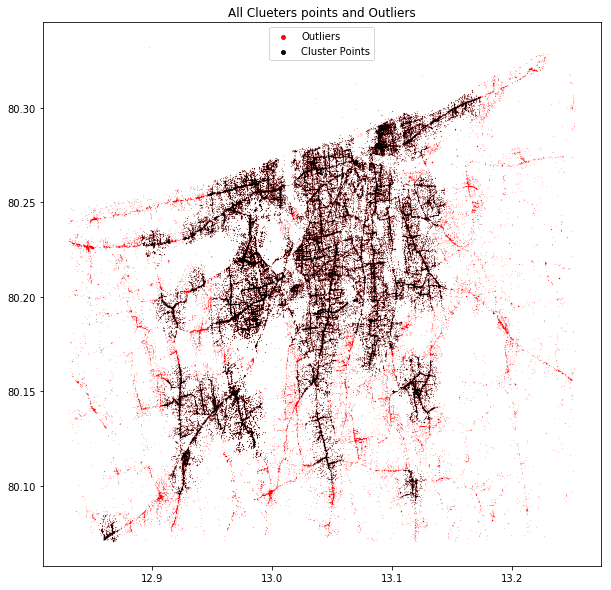

In [167]:
print(Counter(test_11.labels_))

fig1,ax1=plt.subplots(figsize=(10,10))

ax1.scatter(geo.lat,geo.lng,color='red',s=0.005,label=None)
ax1.scatter(cluster_data.lat,cluster_data.lng,color='black',s=0.005,label=None)

ax1.scatter([],[],color='red',s=15,label='Outliers')
ax1.scatter([],[],color='black',s=15,label='Cluster Points')


ax1.set_title('All Clueters points and Outliers')
ax1.legend(loc='best')
plt.show()

Counter({0: 99935, 4: 13784, 2: 3776, 3: 2268, 6: 1632, 7: 1020, 1: 844, 8: 672, 5: 614})


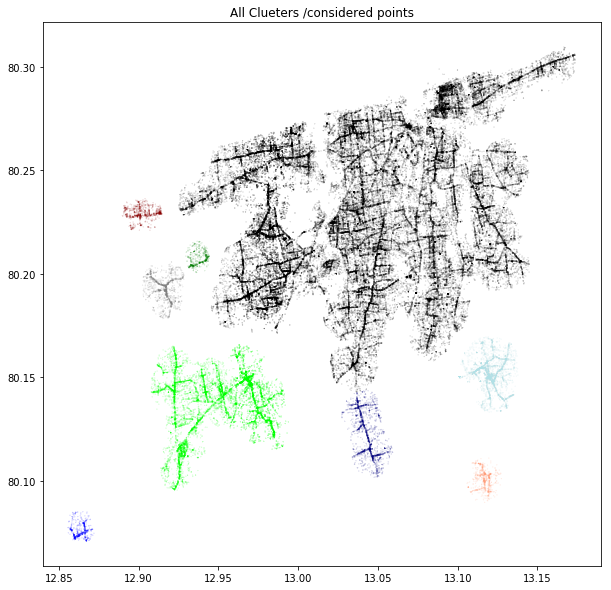

In [168]:
print(Counter(test_11.labels_))

fig1,ax1=plt.subplots(figsize=(10,10))
color_theme=np.array(['black','lightsalmon','powderblue','navy','lime','green','grey','darkred','blue'])
ax1.scatter(cluster_data.lat,cluster_data.lng,color=color_theme[test_11.labels_],s=0.005)
#ax1.scatter(geo.lat,geo.lng,color='black',s=0.003)
ax1.set_title('All Clueters /considered points')
plt.show()

In [169]:
#get all cluster points separated

cluster_0=cluster_data[test_11.labels_==0] # cluster_o without 'id' column 

cluster1_0=cluster_data1[test_11.labels_==0]
cluster1_1=cluster_data1[test_11.labels_==1]
cluster1_2=cluster_data1[test_11.labels_==2]
cluster1_3=cluster_data1[test_11.labels_==3]
cluster1_4=cluster_data1[test_11.labels_==4]
cluster1_5=cluster_data1[test_11.labels_==5]
cluster1_6=cluster_data1[test_11.labels_==6]
cluster1_7=cluster_data1[test_11.labels_==7]
cluster1_8=cluster_data1[test_11.labels_==8]

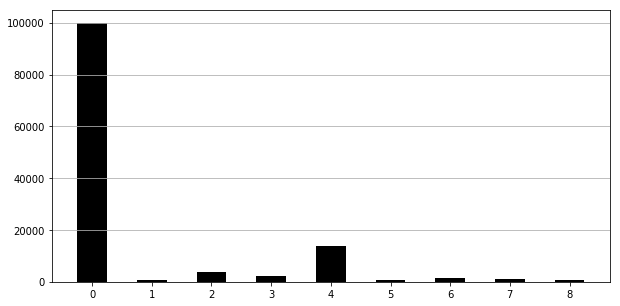

In [170]:
size=[len(cluster1_0),len(cluster1_1),len(cluster1_2),len(cluster1_3),len(cluster1_4),len(cluster1_5),
      len(cluster1_6),len(cluster1_7),len(cluster1_8)]

fig,ax=plt.subplots(figsize=(10,5))
tick_locations=[0,1,2,3,4,5,6,7,8]
ax.bar(tick_locations,size,width=0.5,color='black')
ax.set_xticks(tick_locations)
ax.set_xticklabels(tick_locations)
ax.yaxis.grid(True)
plt.show()

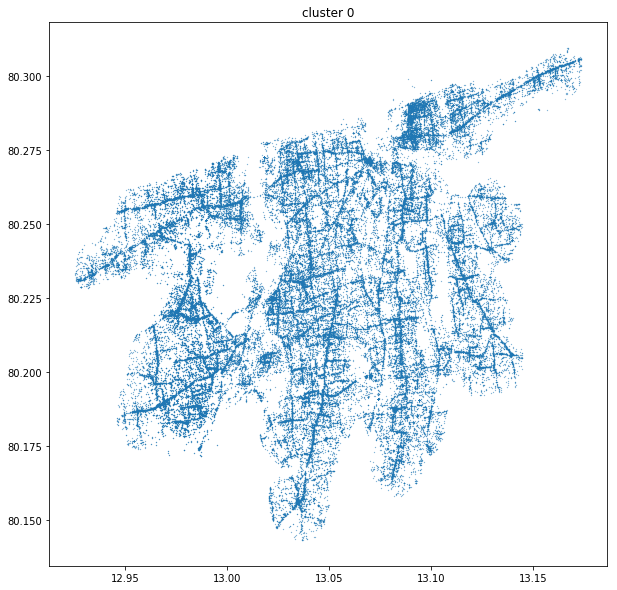

In [171]:
    fig,ax= plt.subplots(figsize=(10,10))
    #colors=model.labels_
    ax.scatter(cluster_0.lat,cluster_0.lng,s=0.05)
    ax.set_title('cluster 0')
    #fig.savefig('/home/nikesh/Documents/cityscooper/point_density/trial0.png')
    plt.show()

In [172]:
cluster1_0.head()

,lat,lng,id
4455,13.162005,80.294994,4455
4456,13.167250,80.299067,4456
4457,13.165779,80.298114,4457
4461,13.169087,80.297488,4461
4466,13.166000,80.298000,4466


# since cluster 0 is too large lets break it into smaller clusters using KMeans

In [173]:
X= cluster_0.values

In [174]:
X

array([[ 13.162005 ,  80.294994 ],
       [ 13.1672501,  80.2990673],
       [ 13.1657794,  80.2981143],
       ..., 
       [ 12.9588522,  80.2573423],
       [ 12.9472487,  80.2407613],
       [ 12.959124 ,  80.2558188]])

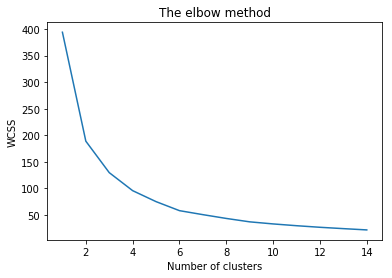

In [175]:
wcss = []

for i in range(1, 15):
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
    
#The elbow method
plt.plot(range(1, 15), wcss)
plt.title('The elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') #within cluster sum of squares
plt.show()

In [176]:
kmeans_clusters=KMeans(n_clusters=9)
kmeans_clusters.fit(X)
Counter(kmeans_clusters.labels_)

Counter({0: 13541,
         1: 10631,
         2: 11960,
         3: 17450,
         4: 13382,
         5: 7698,
         6: 5215,
         7: 10996,
         8: 9062})

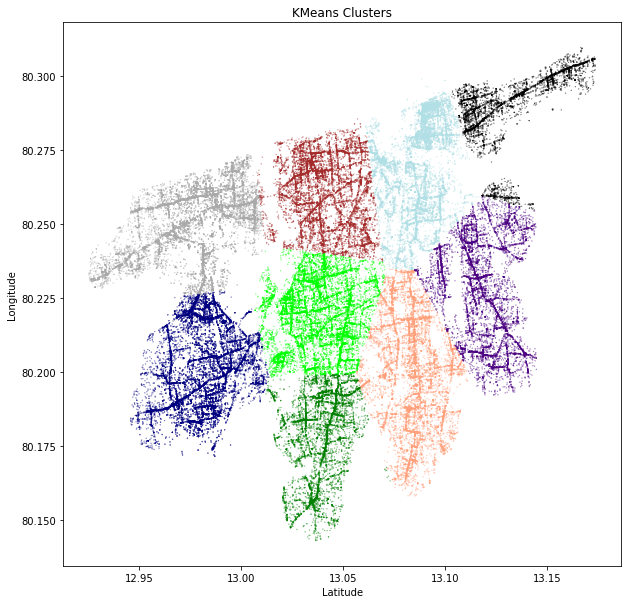

In [177]:
fig,ax=plt.subplots(figsize=(10,10))
color_theme=np.array(['darkgray','lightsalmon','powderblue','navy','lime','green','black','brown','indigo'])
ax.scatter(cluster_0.lat,cluster_0.lng,c=color_theme[kmeans_clusters.labels_],s=0.05)
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
ax.set_title('KMeans Clusters')
plt.show()

## KMeans cluters =9

In [178]:
cluster1_0_0=cluster1_0[kmeans_clusters.labels_==0]
cluster1_0_1=cluster1_0[kmeans_clusters.labels_==1]
cluster1_0_2=cluster1_0[kmeans_clusters.labels_==2]
cluster1_0_3=cluster1_0[kmeans_clusters.labels_==3]
cluster1_0_4=cluster1_0[kmeans_clusters.labels_==4]
cluster1_0_5=cluster1_0[kmeans_clusters.labels_==5]
cluster1_0_6=cluster1_0[kmeans_clusters.labels_==6]
cluster1_0_7=cluster1_0[kmeans_clusters.labels_==7]
cluster1_0_8=cluster1_0[kmeans_clusters.labels_==8]

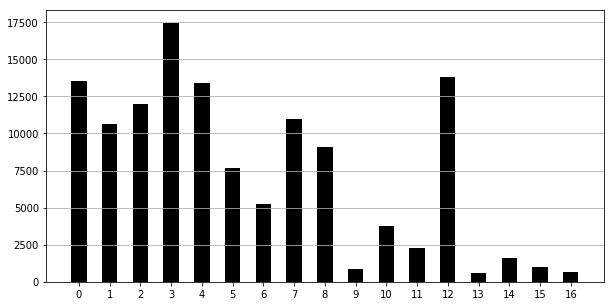

In [179]:
size=[len(cluster1_0_0),len(cluster1_0_1),len(cluster1_0_2),len(cluster1_0_3),len(cluster1_0_4),len(cluster1_0_5)
      ,len(cluster1_0_6),len(cluster1_0_7),len(cluster1_0_8)
      ,len(cluster1_1),len(cluster1_2),len(cluster1_3),len(cluster1_4),len(cluster1_5),
      len(cluster1_6),len(cluster1_7),len(cluster1_8)]

fig,ax=plt.subplots(figsize=(10,5))
tick_locations=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]


ax.bar(tick_locations,size,width=0.5,color='black')
ax.set_xticks(tick_locations)
ax.yaxis.grid(True)
ax.set_xticklabels(tick_locations)
plt.show()

# Disintegrate cluster 0 using dbscan
## -dont want to lose much data
## -big clusters are not accepted


## DBSCAN results are not satisfactory as at all times theres a single large cluster with considerable data loss

In [180]:
dbscan_clusters1=DBSCAN(eps=0.0055,min_samples=500).fit(cluster_0)
Counter(dbscan_clusters1.labels_)

Counter({-1: 8978,
         0: 1278,
         1: 3636,
         2: 3214,
         3: 632,
         4: 40110,
         5: 6659,
         6: 502,
         7: 920,
         8: 1536,
         9: 1904,
         10: 1289,
         11: 28045,
         12: 1232})

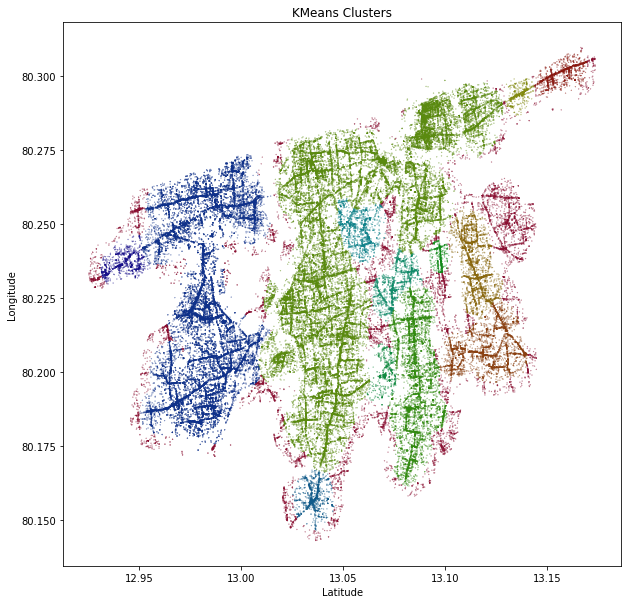

In [181]:
fig,ax=plt.subplots(figsize=(10,10))
ax.scatter(cluster_0.lat,cluster_0.lng,c=colormap[dbscan_clusters1.labels_],s=0.05)
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
ax.set_title('KMeans Clusters')
plt.show()

In [182]:
dbscan_clusters2=DBSCAN(eps=0.0065,min_samples=550).fit(cluster_0)
Counter(dbscan_clusters2.labels_)

Counter({-1: 3054, 0: 1363, 1: 93733, 2: 1162, 3: 623})

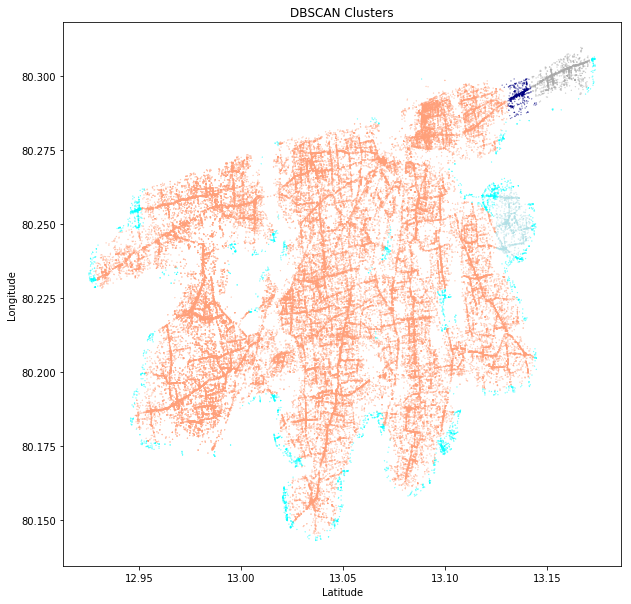

In [183]:
fig,ax=plt.subplots(figsize=(10,10))
color_theme=np.array(['darkgray','lightsalmon','powderblue','navy','lime','green','black','brown','indigo',
                      'black','aqua','salmon','blue','cyan'])
ax.scatter(cluster_0.lat,cluster_0.lng,c=color_theme[dbscan_clusters2.labels_],s=0.05)
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
ax.set_title('DBSCAN Clusters')
plt.show()

In [184]:
dbscan_clusters3=DBSCAN(eps=0.0065,min_samples=650).fit(cluster_0)
Counter(dbscan_clusters3.labels_)

Counter({-1: 7884, 0: 1051, 1: 7313, 2: 81351, 3: 1374, 4: 962})

In [185]:
dbscan_clusters=DBSCAN(eps=0.0065,min_samples=700).fit(cluster_0)
Counter(dbscan_clusters3.labels_)

Counter({-1: 7884, 0: 1051, 1: 7313, 2: 81351, 3: 1374, 4: 962})

In [186]:
dbscan_clusters4=DBSCAN(eps=0.008,min_samples=700).fit(cluster_0)
Counter(dbscan_clusters4.labels_)

Counter({-1: 172, 0: 1648, 1: 98115})

In [187]:
dbscan_clusters=DBSCAN(eps=0.008,min_samples=720).fit(cluster_0)
Counter(dbscan_clusters4.labels_)

Counter({-1: 172, 0: 1648, 1: 98115})

In [188]:
dbscan_clusters5=DBSCAN(eps=0.008,min_samples=750).fit(cluster_0)
Counter(dbscan_clusters5.labels_)

Counter({-1: 833, 0: 1267, 1: 95839, 2: 1415, 3: 581})

In [189]:
dbscan_clusters6=DBSCAN(eps=0.008,min_samples=850).fit(cluster_0)
Counter(dbscan_clusters6.labels_)

Counter({-1: 4459, 0: 1173, 1: 94303})

# Set of cluster ids

In [190]:
id_0_0=set(cluster1_0_0['id'])
id_0_1=set(cluster1_0_1['id'])
id_0_2=set(cluster1_0_2['id'])
id_0_3=set(cluster1_0_3['id'])
id_0_4=set(cluster1_0_4['id'])
id_0_5=set(cluster1_0_5['id'])
id_0_6=set(cluster1_0_6['id'])
id_0_7=set(cluster1_0_7['id'])
id_0_8=set(cluster1_0_8['id'])
id_1=set(cluster1_1['id'])
id_2=set(cluster1_2['id'])
id_3=set(cluster1_3['id'])
id_4=set(cluster1_4['id'])
id_5=set(cluster1_5['id'])
id_6=set(cluster1_6['id'])
id_7=set(cluster1_7['id'])
id_8=set(cluster1_8['id'])

In [191]:
total=len(id_0_0)+len(id_0_1)+len(id_0_2)+len(id_0_3)+len(id_0_4)+len(id_0_5)+len(id_0_6)+len(id_0_7)+len(id_0_8)+len(id_1)+len(id_2)+len(id_3)+len(id_4)+len(id_5)+len(id_6)+len(id_7)+len(id_8)
total

124545

# Cluster Analysis

In [192]:
# Categories analysis for chennai
chennai=analysis(total_points)

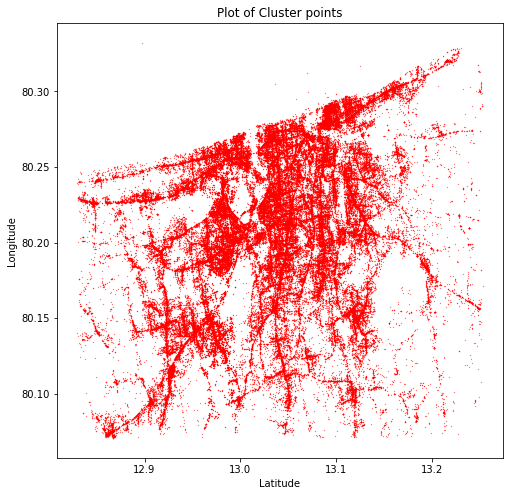

In [193]:
chennai.graph()
#blue dots represent the points have not considered in supercategory (food store not analysed yet)

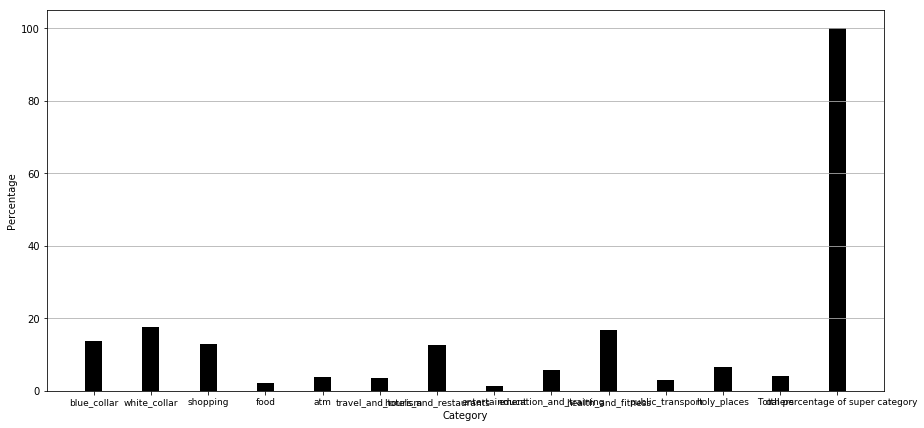

,PlaceType,Percentage,Relative percent
0,blue_collar,13.72137,100.0
1,white_collar,17.67311,100.0
2,shopping,12.91671,100.0
3,food,2.14442,100.0
4,atm,3.88284,100.0
5,travel_and_tourism,3.53235,100.0
6,hotels_and_restaurants,12.76019,100.0
7,entertainment,1.40130,100.0
8,education_and_training,5.82058,100.0
9,health_and_fitness,16.87714,100.0


In [194]:
ch=chennai.percentage(super_category_dic)

plotbar(ch)
ch

In [195]:
chennai.percentage(white_collar_dic)

,PlaceType,Percentage,Relative percent
0,moving_company,0.342470,100.0
1,bicycle_store,0.377250,100.0
2,hardware_store,2.343750,100.0
3,car_repair,4.768430,100.0
4,car_wash,0.256180,100.0
5,plumber,0.307020,100.0
6,electrician,0.353170,100.0
7,aquarium,0.202670,100.0
8,roofing_contractor,0.176580,100.0
9,furniture_store,2.211310,100.0


In [196]:
c05=analysis(id_0_5)

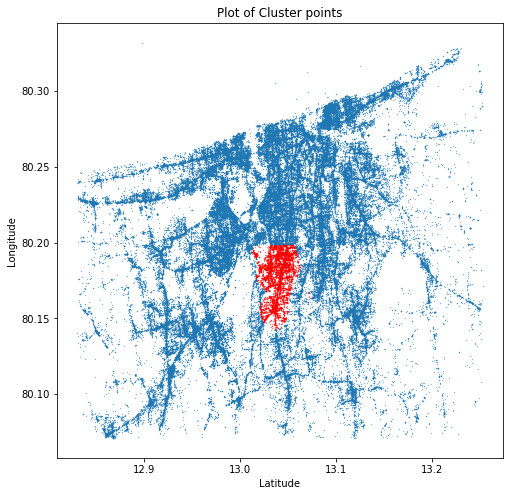

In [197]:
c05.graph()

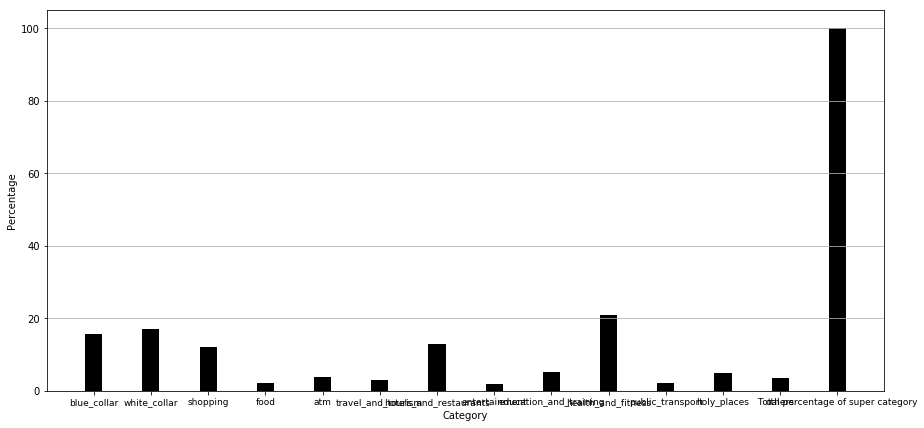

,PlaceType,Percentage,Relative percent
0,blue_collar,15.80930,5.932534
1,white_collar,17.03040,4.961774
2,shopping,12.02910,4.795194
3,food,2.09145,5.021834
4,atm,3.81917,5.064599
5,travel_and_tourism,2.98779,4.355236
6,hotels_and_restaurants,13.01637,5.252398
7,entertainment,1.75370,6.443914
8,education_and_training,5.13120,4.539186
9,health_and_fitness,20.92751,6.384750


In [198]:
sc=c05.percentage(super_category_dic)
plotbar(sc)
sc

In [200]:
c05.percentage(shopping_dic)

,PlaceType,Percentage,Relative percent
0,supermarket,0.090930,2.621723
1,clothing_store,5.183160,5.133814
2,shopping_mall,2.364250,5.048544
3,jewelry_store,2.026500,4.502165
4,department_store,0.766430,3.753181
5,convenience_store,0.038970,6.818182
6,grocery_or_supermarket,0.181870,1.909959
7,shoe_store,1.584830,4.848967
8,Total percentage of super category,12.029098,4.795194


In [201]:
c05.percentage(health_and_fitness_dic)

,PlaceType,Percentage,Relative percent
0,pharmacy,2.883870,6.228956
1,hair_care,2.870880,6.567608
2,spa,0.909330,6.439742
3,physiotherapist,0.103920,2.564103
4,dentist,2.221360,6.914679
5,beauty_salon,4.923360,8.278724
6,veterinary_care,0.181870,6.167401
7,gym,1.896600,5.674310
8,hospital,3.390490,5.492424
9,doctor,2.987790,6.167873


In [202]:
c05.percentage(hotels_and_restaurants_dic)

,PlaceType,Percentage,Relative percent
0,bar,0.454660,4.623514
1,meal_delivery,0.168880,9.420290
2,meal_takeaway,0.740450,4.773869
3,restaurant,5.715770,5.241839
4,lodging,5.027280,5.423966
5,cafe,2.286310,5.430423
6,night_club,0.051960,2.702703
7,Total percentage of super category,13.016368,5.252398


# Removed points indexes

In [203]:
len(city)

149566

In [204]:
removed_points_index=[]
for index,dic in enumerate(city):
    if len(dic)==0:
        removed_points_index.append(index)
        
print('total number of removed points = ',len(removed_points_index),'\n\n',removed_points_index)

total number of removed points =  60 

 [11598, 35507, 37059, 46120, 65929, 65930, 65931, 65932, 65933, 65934, 65935, 65936, 65937, 65938, 65939, 65940, 65941, 65942, 65943, 65944, 65945, 65946, 65947, 65948, 65949, 65950, 65951, 65952, 65953, 65954, 65955, 65956, 65957, 65958, 65959, 65960, 65961, 65962, 65963, 65964, 65965, 65966, 65967, 65968, 65969, 65970, 65971, 65972, 65973, 65974, 91672, 114008, 115013, 115116, 120813, 120896, 127202, 127238, 135329, 137997]


In [205]:
missing_point_index=[11598, 35507, 37059, 46120, 65929, 65930, 65931, 65932, 65933, 65934, 65935, 65936, 65937, 65938, 65939, 65940, 65941, 65942, 65943, 65944, 65945, 65946, 65947, 65948, 65949, 65950, 65951, 65952, 65953, 65954, 65955, 65956, 65957, 65958, 65959, 65960, 65961, 65962, 65963, 65964, 65965, 65966, 65967, 65968, 65969, 65970, 65971, 65972, 65973, 65974, 91672, 114008, 115013, 115116, 120813, 120896, 127202, 127238, 135329, 137997]

In [206]:
near_ids=[]
for i in range(65922,65935): # continuous index as the geo(without missing values) and city are of differet length
    near_ids.append(i)
    
print(near_ids)

[65922, 65923, 65924, 65925, 65926, 65927, 65928, 65929, 65930, 65931, 65932, 65933, 65934]


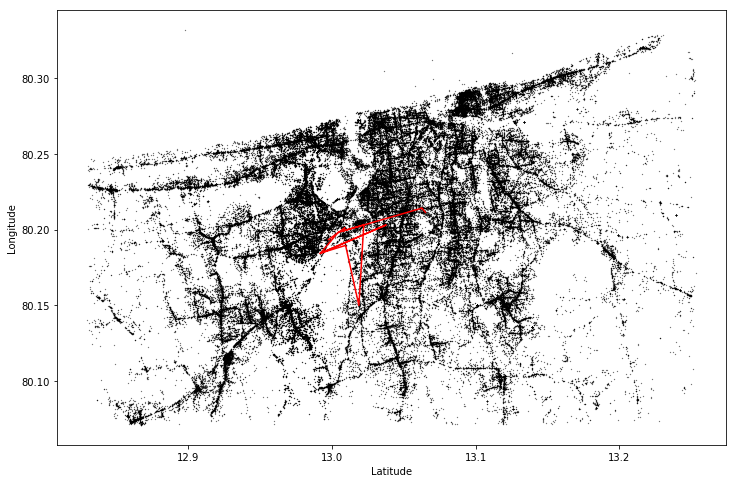

In [207]:
near_lat=[]
near_lng=[]

for i in near_ids:
    near_lat.append(geo.lat.iloc[i])
    near_lng.append(geo.lng.iloc[i])
    
fig,ax=plt.subplots(figsize=(12,8))
ax.scatter(geo.lat,geo.lng,color='black',s=0.05)
ax.plot(near_lat,near_lng,color='red')
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
plt.show()

### this is the approx area for most of the missing points